## Compute forecast metrics using item-level backtests

<b>DC Bikeshare Rentals data</b>

Our goal is to predict the number of DC Bikeshare rentals in the next 24 hours for each of 467 rental locations.  To do this, we used Amazon Forecast to create forecasts with 1 hour frequency and 1 week forecast horizon.   
<ul>
    <li>See <a href="https://aws.amazon.com/blogs/machine-learning/measuring-forecast-model-accuracy-to-optimize-your-business-objectives-with-amazon-forecast/, target='_blank' ">blog post for screens how the forecast was created.</a></li>
<li>Original data source: <a href="https://www.capitalbikeshare.com/system-data", target='_blank'"> https://www.capitalbikeshare.com/system-data</a> </li>
    </ul>  

This notebook picks up after the blog post Predictor has been trained.  In the overall Amazon Forecast workflow, this notebook covers <i>step 6. Inspect the model using the backtest window forecasts, see context below.</i>
<br><br>


<b>Overall process for using Amazon Forecast:</b>

![alt text](images/forecast_steps_overview.png "Amazon Forecast overview workflow")

<ol>
    <li>Prepare your data and save up to 3 separate .csv files.  In Forecast there are  3 types of Datasets (Target, Related, and Meta data). <br>
        <ul>
        <li>The Target Time Series is required, it is the historical values of what you're trying to predict, i.e. historical y-values or target values.  The others provide additional context with certain algorithms. <br>
        </ul><br>
    <li>Per dataset, you will specify the schema. </li>
    <li>Per dataset, create a Data Import Job. Give the S3 location where data will be read from. </li>
    <li>Create a Dataset Group.  This is a container that groups together your models, data they are trained on, and forecasts.  <br>
        <ul>
            <li>Having this grouping is convenient if in the future, you want to look up artifacts how you ran a particular forecast. </li>
        <li>The Dataset Group is also how you can run inferences (forecasts) in the future, without retraining, just by importing new data, by creating a new Data Import job.  </li>
        </ul><br>
    <li>Train a model.  Amazon Forecast offers AutoML to do this process for you, but you can also select a particular algorithm (6 built-in algorithms).  AutoML will do Hyper Parameter Optimization(HPO) to determine the most performant values automatically, or you can select your own values.</li>
    <b><li>Inspect the model using the backtest window forecasts. This notebook focuses on this step.</li>
    <ul>
    <li>We will use the built-in feature of Amazon Forecast that exports backtest window forecasts together with actuals, for Predictor analysis.  </li>
    <li>Predictor evaluation is recommended to make an informed decision whether to deploy the current Predictor to make Forecasts, or whether to fix something in the data setup and train a new Predictor. </li></b>
    </ul><br>
    <li>Deploy the model (or create a forecast).  Here you are deploying your model so you can use it to do inferences (or generate forecasts).</li>
    <li>Query and visualize the Forecast (available in console UI). Spot-check actual values and forecasted values at different quantiles in the console for a particular itemID. The visualization feature in the console is basic, not user-interactive.  For more advanced visualizations, consider exporting your forecasts to an S3 location and point your BI tool (e.g. Tableau or Quicksight) to that data.</li>
    </ol>
<br>


<b>Table Of Contents for task of inspecting the model using the backtest window forecasts</b>
* [Set up and install libraries](#setup)
* [Export predictor backtests](#export)
* [Assemble and read predictor backtest files](#read)
* [Demo using item-level forecast files](#demo)
* [Visualize backtest window accuracy](#visualizations)
* [Calculate custom MAPE](#mape)

<br>

## Set up  <a class="anchor" id="setup"></a>
Import and install Python and aws libraries


In [1]:
import sys
import os
import glob
import shutil
import time
import datetime
from datetime import timedelta
import random

import pandas as pd
print('pandas: {}'.format(pd.__version__))
# display all columns wide
pd.set_option('display.max_columns', None)
# display all rows long
pd.set_option('display.max_rows', None)
# display horizontal scrollbar for wide columns
pd.set_option('display.width', 5000)
pd.set_option('display.max_colwidth', 5000)
#turn off scientific notation
pd.set_option('display.float_format', lambda x: '%.5f' % x)

import numpy as np
print('numpy: {}'.format(np.__version__))
import matplotlib.pyplot as plt
%matplotlib inline 


# Python library for AWS APIs
import boto3

# importing forecast notebook utility from notebooks/common directory
sys.path.insert( 0, os.path.abspath("../../common") )
import util

pandas: 1.1.4
numpy: 1.18.1


In [2]:
# display ipython widgets in notebook
!pip install ipywidgets
!jupyter nbextension enable --py --sys-prefix widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [3]:
### TODO delete later
# util doesn't exist so create locally
import ipywidgets


widget_table = {}

def create_text_widget( name, placeholder, default_value="" ):
    
    layout = ipywidgets.Layout(horz="top", object_fit="scale-down"
                               , width='auto'
                               , display="flex"
                              ) 

    if name in widget_table:
        widget = widget_table[name]
    if name not in widget_table:
        widget = ipywidgets.Text( description = name, placeholder = placeholder
                                 , value=default_value 
                                 , layout = layout)
        widget_table[name] = widget
    display(widget)
    
    return widget



class StatusIndicator:
    
    def __init__(self):
        self.previous_status = None
        self.need_newline = False
        
    def update( self, status ):
        if self.previous_status != status:
            if self.need_newline:
                sys.stdout.write("\n")
            sys.stdout.write( status + " ")
            self.need_newline = True
            self.previous_status = status
        else:
            sys.stdout.write(".")
            self.need_newline = True
        sys.stdout.flush()

    def end(self):
        if self.need_newline:
            sys.stdout.write("\n")


In [4]:
#########
# Functions to calculate item velocity and classify items a "slow" or "fast"
#########

def get_velocity_per_item(df, timestamp_col, item_id_col="item_id"):
    """Calculate item velocity as item demand per hour.  
    """
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], format='%Y-%m-%d %H:%M:%S')
    
    max_time_df = df.groupby([item_id_col], as_index=False).max()[[item_id_col, timestamp_col]]
    max_time_df.columns = [item_id_col, 'max_time']
    
    min_time_df = df.groupby([item_id_col], as_index=False).min()[[item_id_col, timestamp_col]]
    min_time_df.columns = [item_id_col, 'min_time']
    
    df = df.merge(right=max_time_df, on=item_id_col)
    df = df.merge(right=min_time_df, on=item_id_col)
    
    df['time_span'] = df['max_time'] - df['min_time']
    df['time_span'] = df['time_span'].apply(lambda x: x.seconds / 3600 + 1) # add 1 to include start datetime and end datetime
    df = df.groupby([item_id_col], as_index=False).agg({'time_span':'mean', 'target_value':'sum'})
    df['velocity'] = df['target_value'] / df['time_span']
    return df


def get_fast_slow_moving_items_all(gt_df
                                   , timestamp_col
                                   , target_value_col
                                   , item_id_col="item_id"):
    """Calculate mean velocity over all items as "criteria".
       Assign each item into category "fast" or "slow" depending on whether its velocity > criteria.
    """
    gt_df_velocity = gt_df[[item_id_col, timestamp_col, target_value_col]].copy().reset_index(drop=True)
    gt_df_velocity = get_velocity_per_item(gt_df_velocity, timestamp_col, item_id_col)
    criteria = gt_df_velocity['velocity'].mean()
    gt_df_velocity['fast_moving'] = gt_df_velocity['velocity'] > criteria
    print('average velocity of all items:', criteria)
    
    fast_moving_items = gt_df_velocity[gt_df_velocity['fast_moving'] == True][item_id_col].to_list()
    slow_moving_items = gt_df_velocity[gt_df_velocity['fast_moving'] == False][item_id_col].to_list()
    return fast_moving_items, slow_moving_items


###########
# Define custom metrics
###########

def truncate_negatives_to_zero(the_df, target_value_col, quantile_cols):
    """In case you are expecting positive numbers for actuals and predictions,
       round negative values up to zero.
       
       Be careful that this is acceptable treatment of negatives for your use case.
    """
    
    df = the_df.copy()
    
    for q in quantile_cols:
        num_neg_predictions = df[q].lt(0).sum()
        print(f"Num negative {q} predictors: {num_neg_predictions}")

        # replace
        df[q] = df[q].mask(df[q] < 0, 0)

        # check you did the right thing
        num_neg_predictions = df[q].lt(0).sum()
        print(f"Num negative {q} predictors: {num_neg_predictions}")

    # truncate negative actuals
    num_neg_actuals = df[target_value_col].lt(0).sum()
    print(f"Num negative actuals: {num_neg_actuals}")

    # replace
    df[target_value_col] = df[target_value_col].mask(df[target_value_col] < 0, 0)

    # check you did the right thing
    num_neg_actuals = df[target_value_col].lt(0).sum()
    print(f"Num negative actuals: {num_neg_actuals}")
    
    return df

       
def calc_mape(target, forecast):
    """Calculates custom mape for a specific quantile and window with formula:
            sum(| |predicted| - |actual| | / |actual|)
       Input: single numbers for target and forecast
       Output: mape = floating point number
    """
    denominator = np.abs(target)
    flag = denominator <= 1e-8

    mape = np.mean(
        (np.abs( np.abs(target) - np.abs(forecast)) * (1.0 - flag)) / (denominator + flag)
    )
    return mape



In order to run Amazon Forecast, you'll need an AWS account.  
<b>Make sure you can log in to: https://console.aws.amazon.com/.  </b>  Then read each cell carefully and execute the cells in this notebook.
<br>
<br>

<b>Configure the S3 bucket name and region name for this lesson.</b>

- If you don't have an S3 bucket, create it first on S3.
- Although we have set the region to us-west-2 as a default value below, you can choose any of the regions that the service is available in.

In [5]:

text_widget_bucket = util.create_text_widget( "bucket_name", "input your S3 bucket name"
                                             , default_value="bike-demo" )
text_widget_region = util.create_text_widget( "region", "input region name."
                                             , default_value="us-west-2" )

Text(value='bike-demo', description='bucket_name', layout=Layout(display='flex', object_fit='scale-down', widt…

Text(value='us-west-2', description='region', layout=Layout(display='flex', object_fit='scale-down', width='au…

In [ ]:

## echo user inputs

BUCKET_NAME = text_widget_bucket.value
print(f"bucket = {BUCKET_NAME}")
assert BUCKET_NAME, "bucket_name not set."

REGION = text_widget_region.value
print(f"REGION = {REGION}")
assert REGION, "region not set."

In [7]:
# S3 bucket settings
s3 = boto3.client('s3')
# s3_resource = boto3.resource('s3') - not used here

The next part of the setup process is to validate that your account can communicate with Amazon Forecast

In [8]:
# Initialize forecast session
session = boto3.Session(region_name=REGION) 
forecast = session.client(service_name='forecast') #Amazon Forecast Service api session
# forecastquery = session.client(service_name='forecastquery') #Amazon Forecast Query api session - not used here


The last part of the setup process is to create an AWS Role with Forecast and S3 permissions

In [ ]:
# Create the role to provide to Amazon Forecast.

role_name = "ForecastNotebookRole"
print(f"Creating Role {role_name} ...")
role_arn = util.get_or_create_iam_role( role_name = role_name )


### Export predictor backtests <a class="anchor" id="export"></a>

"Backtesting" is a cross-validation technique for time series that uses multiple train/test splits that keep time order of the data.  Using multiple train-test splits (i.e. more than 1 backtest window) will result in more models being trained, and in turn, a more robust estimate how the model (chosen algorithm and hyperameters) will perform on unseen data.
<a href="https://docs.aws.amazon.com/forecast/latest/dg/metrics.html#backtesting, target='_blank' ">More details on the Amazon Forecast documentation page.</a>

In the next few cells, we ask for your Predictor arn and S3 location where to write the backtest export files.

In [10]:

text_widget_predictor_arn = util.create_text_widget( "predictor_arn", "input your Forecast Predictor arn"
                    , default_value="arn:aws:forecast:us-west-2:123456789012:predictor/bike_demo_auto")

text_widget_export_path = util.create_text_widget( "export_path", "input export path"
                    , default_value="s3://bike-demo/forecasts/bike_demo_auto/bike_backtest_export_files/" )


Text(value='arn:aws:forecast:us-west-2:123456789012:predictor/bike_demo_auto', description='predictor_arn', la…

Text(value='s3://bike-demo/forecasts/bike_demo_auto/bike_backtest_export_files/', description='export_path', l…

In [ ]:

## echo user inputs

predictor_arn = text_widget_predictor_arn.value
print(f"Predictor arn = {predictor_arn}")
assert predictor_arn, "predictor_arn not set."

export_path = text_widget_export_path.value
print(f"Export_path = {export_path}")
assert export_path, "export_path not set."

<br>
In the next few cells, we ask Amazon Forecast to export the Predictor backtest window forecasts via API.  The same could be done by <a href="https://aws.amazon.com/blogs/machine-learning/measuring-forecast-model-accuracy-to-optimize-your-business-objectives-with-amazon-forecast/, target='_blank' ">clicking the "Export backtest results" button on the Predictor page, as shown in the blog.</a>
<br>
<br>

In [13]:

## Call CreatePredictorBacktestExportJob using predictor Arn and S3 export path

backtestExportJobName = 'bike_demo_forecasts'
backtest_export_job_response =forecast.create_predictor_backtest_export_job(PredictorBacktestExportJobName=backtestExportJobName,
                                                          PredictorArn=predictor_arn,
                                                          Destination= {
                                                              "S3Config" : {
                                                                 "Path":export_path,
                                                                 "RoleArn": role_arn
                                                              } 
                                                          })

In [14]:

# check for HTTPStatusCode 200

backtest_export_job_response

{'PredictorBacktestExportJobArn': 'arn:aws:forecast:us-west-2:938097332257:predictor-backtest-export-job/bike_demo2_auto/bike_demo_r_forecasts',
 'ResponseMetadata': {'RequestId': 'f22a36a6-deac-43fe-acbc-14dda8c50387',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Tue, 24 Nov 2020 20:07:51 GMT',
   'x-amzn-requestid': 'f22a36a6-deac-43fe-acbc-14dda8c50387',
   'content-length': '143',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [15]:

## CHECK STATUS OF YOUR EXPORT JOB - BACKTEST FORECASTS

# status_indicator = util.StatusIndicator()
# TODO delete this and put above back
status_indicator = StatusIndicator()

while True:
    status = forecast.describe_predictor_backtest_export_job(PredictorBacktestExportJobArn = \
                        backtest_export_job_response['PredictorBacktestExportJobArn'])['Status']
    status_indicator.update(status)
    if status in ('ACTIVE', 'CREATE_FAILED'): break
    time.sleep(10)

status_indicator.end()

# Wait until you see "ACTIVE" below...
# This will take a while, go get a cup of tea now.  

CREATE_PENDING .
CREATE_IN_PROGRESS ................................
ACTIVE 


<br>
The API steps you did above, could equivalently be done in the UI by clicking the "Export backtest results" button on the Predictor page.  You'll see export job details on the screen.

![alt text](images/export_backtest_results.png "Export backtest results")

## Assemble and read predictor backtest files <a class="anchor" id="read"></a>

After Forecast Predictor Backtest Export step finishes, you will have a number of .part files within 2 separate folders.  The cell below concatenates all the .part files per folder into a single .csv file which can be saved to an S3 location of your choice. <br>

Make sure to change each section below with <b><i>your S3 locations where you want to save backtest files.</i></b>.
<br>

In [ ]:
#################
# REPLACE file names below and re-run for each export file
temp_file = "bike_backtest_accuracies.csv"
to_file_accuracies = f"s3://{BUCKET_NAME}/bike_share_open_data/demo/{temp_file}"
print(f"to file: {to_file_accuracies}")
#################

from_files = f"{export_path}accuracy-metrics-values/"
print(f"from file: {from_files}")

In [ ]:
# THIS WORKS FOR ANY OS

# copy part files locally
try:
    shutil.rmtree("tempfcst")
except OSError:
    pass
os.makedirs("tempfcst")
!aws s3 cp $from_files tempfcst/ --recursive --include "*.csv"
    
# # Concat .csv part files locally
os.system('touch {}'.format(temp_file))
# !cat tempfcst/*csv > $temp_file
path = r'tempfcst'
allFiles = glob.glob(path + "/*.csv")
with open(temp_file, 'wb') as outfile:
    for i, fname in enumerate(allFiles):
        with open(fname, 'rb') as infile:
            if i != 0:
                infile.readline()  # Throw away header on all but first file
            # Block copy rest of file from input to output without parsing
            shutil.copyfileobj(infile, outfile)
            print(fname + " has been imported.")

# # copy concatted local .csv file back to S3
!aws s3 cp $temp_file $to_file_accuracies

In [ ]:
#################
# REPLACE file names below and re-run for each export file
temp_file = "bike_backtest_forecasts.csv"
to_file_forecasts = f"s3://{BUCKET_NAME}/bike_share_open_data/demo/{temp_file}"
print(f"to file: {to_file_forecasts}")
#################

from_files = f"{export_path}forecasted-values/"
print(f"from file: {from_files}")

In [ ]:
# THIS WORKS FOR ANY OS

# copy part files locally
try:
    shutil.rmtree("tempfcst")
except OSError:
    pass
os.makedirs("tempfcst")
!aws s3 cp $from_files tempfcst/ --recursive --include "*.csv"
    
# # Concat .csv part files locally
os.system('touch {}'.format(temp_file))
# !cat tempfcst/*csv > $temp_file
path = r'tempfcst'
allFiles = glob.glob(path + "/*.csv")
with open(temp_file, 'wb') as outfile:
    for i, fname in enumerate(allFiles):
        with open(fname, 'rb') as infile:
            if i != 0:
                infile.readline()  # Throw away header on all but first file
            # Block copy rest of file from input to output without parsing
            shutil.copyfileobj(infile, outfile)
            print(fname + " has been imported.")

# copy concatted local .csv file back to S3
!aws s3 cp $temp_file $to_file_forecasts

In [20]:

## READ THE ACCURACIES FILE

accuracy_df = pd.read_csv(to_file_accuracies)

# keep only data rows
print(accuracy_df.shape)
accuracy_df = accuracy_df.loc[(accuracy_df.backtestwindow_start_time != "backtestwindow_start_time"), :].copy()
print(accuracy_df.shape)

# correct data types
accuracy_df.item_id = accuracy_df.item_id.astype(str)
accuracy_df['backtestwindow_start_time'] = pd.to_datetime(accuracy_df['backtestwindow_start_time']
                                                 , format="%Y-%m-%dT%H:%M:%S", errors='coerce')
accuracy_df['backtestwindow_end_time'] = pd.to_datetime(accuracy_df['backtestwindow_end_time']
                                                 , format="%Y-%m-%dT%H:%M:%S", errors='coerce')
# convert UTC timestamp to timezone unaware
accuracy_df['backtestwindow_start_time'] = accuracy_df.backtestwindow_start_time.dt.tz_localize(None)
accuracy_df['backtestwindow_end_time'] = accuracy_df.backtestwindow_end_time.dt.tz_localize(None)

# correct dtypes
for q in accuracy_df.iloc[:, -4:].columns:
    accuracy_df[q] = pd.to_numeric(accuracy_df[q], errors='coerce')

# check
num_items = len(accuracy_df['item_id'].value_counts(normalize=True, dropna=False))
print(f"Num items: {num_items}")
print("Backtest Window Start Dates")
print(accuracy_df.backtestwindow_start_time.unique())

print(accuracy_df.dtypes)
accuracy_df.sample(5)

(11208, 8)
(11208, 8)
Num items: 467
Backtest Window Start Dates
['2017-06-19T00:00:00.000000000' '2017-06-21T00:00:00.000000000'
 '2017-06-20T00:00:00.000000000' '2017-06-22T00:00:00.000000000'
 '2017-06-23T00:00:00.000000000']
item_id                              object
backtest_window                      object
backtestwindow_start_time    datetime64[ns]
backtestwindow_end_time      datetime64[ns]
wQL[0.65]                           float64
wQL[0.9]                            float64
RMSE                                float64
WAPE                                float64
dtype: object


,item_id,backtest_window,backtestwindow_start_time,backtestwindow_end_time,wQL[0.65],wQL[0.9],RMSE,WAPE
2777,31108,Summary,2017-06-19,2017-06-23 23:00:00,0.42267,0.26547,2.29061,37.32429
10424,31081,Computed,2017-06-23,2017-06-23 23:00:00,1.10942,1.02015,1.01431,15.66055
6266,31054,Computed,2017-06-20,2017-06-20 23:00:00,0.08036,0.04594,0.00340,0.07928
10483,31915,Computed,2017-06-21,2017-06-21 23:00:00,0.99935,1.06349,0.47115,6.02110
5159,31018,Computed,2017-06-21,2017-06-21 23:00:00,1.24369,1.20427,0.75478,9.55451


In [21]:

## READ THE FORECASTS FILE

df = pd.read_csv(to_file_forecasts)

# correct data types
df.item_id = df.item_id.astype(str)
df.target_value = pd.to_numeric(df.target_value, errors='coerce')
df.timestamp = pd.to_datetime(df.timestamp
                                                 , format="%Y-%m-%dT%H:%M:%S", errors='coerce')
df['backtestwindow_start_time'] = pd.to_datetime(df['backtestwindow_start_time']
                                                 , format="%Y-%m-%dT%H:%M:%S", errors='coerce')
df['backtestwindow_end_time'] = pd.to_datetime(df['backtestwindow_end_time']
                                                 , format="%Y-%m-%dT%H:%M:%S", errors='coerce')
# convert UTC timestamp to timezone unaware
df.timestamp = df.timestamp.dt.tz_localize(None)

# check
num_items = len(df['item_id'].value_counts(normalize=True, dropna=False))
print(f"Num items: {num_items}")
print()
print("Backtest Window Start Dates")
print(df.backtestwindow_start_time.unique())

print(df.dtypes)
df.sample(5)

Num items: 467

Backtest Window Start Dates
['2017-06-19T00:00:00.000000000' '2017-06-20T00:00:00.000000000'
 '2017-06-21T00:00:00.000000000' '2017-06-22T00:00:00.000000000'
 '2017-06-23T00:00:00.000000000']
item_id                              object
timestamp                    datetime64[ns]
target_value                        float64
backtestwindow_start_time    datetime64[ns]
backtestwindow_end_time      datetime64[ns]
mean                                float64
p65                                 float64
p90                                 float64
dtype: object


,item_id,timestamp,target_value,backtestwindow_start_time,backtestwindow_end_time,mean,p65,p90
46910,31063,2017-06-23 04:00:00,0.00000,2017-06-23,2017-06-23 23:00:00,0.00110,0.00133,0.00247
76682,31259,2017-06-20 20:00:00,2.00000,2017-06-20,2017-06-20 23:00:00,0.25778,0.59890,1.04670
83620,31625,2017-06-21 11:00:00,1.00000,2017-06-21,2017-06-21 23:00:00,1.62375,1.80973,3.40034
52165,31619,2017-06-23 16:00:00,0.00000,2017-06-23,2017-06-23 23:00:00,3.11342,3.67579,5.35981
174954,31080,2017-06-19 15:00:00,0.00000,2017-06-19,2017-06-19 23:00:00,0.22169,0.33026,0.85235


## Demo using the item-level forecast files <a class="anchor" id="demo"></a>

The rest of this notebook will focus on how to use the item-level forecasts from the Predictor backtest windows. 
<br>

#### Get quantile columns

In [22]:
# Map column names in your data to expected key words
item_id = "item_id"
target_value = "target_value"
timestamp = "timestamp"
location_id = "item_id"

In [23]:
# target = "target_value"
# set predictor dimensions from forecast df
predictor_cols = ['item_id', 'timestamp', 'rest_no', 'backtestwindow_start_time', 'backtestwindow_end_time']
# exclude cols to automatically find quantiles
exclude_cols = predictor_cols.copy()
exclude_cols.append(target_value)

# get quantile columns from forecast dataframe
quantile_cols = [c for c in df.columns if c not in exclude_cols] 
num_quantiles = len(quantile_cols)
print(f"num quantiles: {num_quantiles}")
quantile_cols

num quantiles: 3


['mean', 'p65', 'p90']

In [24]:
# correct data types
for q in quantile_cols:
    df[q] = pd.to_numeric(df[q], errors='coerce')

print(df.dtypes)
df.sample(5)

item_id                              object
timestamp                    datetime64[ns]
target_value                        float64
backtestwindow_start_time    datetime64[ns]
backtestwindow_end_time      datetime64[ns]
mean                                float64
p65                                 float64
p90                                 float64
dtype: object


,item_id,timestamp,target_value,backtestwindow_start_time,backtestwindow_end_time,mean,p65,p90
6791,31924,2017-06-19 14:00:00,0.00000,2017-06-19,2017-06-19 23:00:00,-0.00290,-0.00115,0.00113
91344,31405,2017-06-22 04:00:00,0.00000,2017-06-22,2017-06-22 23:00:00,0.00335,0.00520,0.01363
207030,31412,2017-06-22 12:00:00,0.00000,2017-06-22,2017-06-22 23:00:00,0.00122,0.00140,0.00304
158025,31503,2017-06-23 03:00:00,0.00000,2017-06-23,2017-06-23 23:00:00,0.00771,0.00878,0.01823
121580,31903,2017-06-19 21:00:00,0.00000,2017-06-19,2017-06-19 23:00:00,-0.00289,-0.00126,0.00297


#### Before calling error calcs, truncate negative actuals and predictions to 0
If you are not expecting negatives, such as for counts

In [25]:

### Before calling error calcs, truncate negative actuals and predictions to 0

df_eligible = df.copy()
df_eligible = truncate_negatives_to_zero(df_eligible
                                         , target_value_col=target_value
                                         , quantile_cols=quantile_cols)


Num negative mean predictors: 56664
Num negative mean predictors: 0
Num negative p65 predictors: 45528
Num negative p65 predictors: 0
Num negative p90 predictors: 1468
Num negative p90 predictors: 0
Num negative actuals: 0
Num negative actuals: 0


In [26]:
# Add day of week for convenience
df_eligible['day_of_week'] = df_eligible.timestamp.dt.day_name()
print(df_eligible.day_of_week.value_counts())

# Add window number for convenience
windows = df_eligible.backtestwindow_start_time.value_counts().rename_axis('backtestwindow_start_time').reset_index(name='count')
windows.sort_values('backtestwindow_start_time', inplace=True)
windows.reset_index(inplace=True, drop=True)
windows.drop('count', axis=1, inplace=True)
windows['window'] = windows.index + 1

print(df_eligible.shape)
df_eligible = df_eligible.merge(windows, how="left", on="backtestwindow_start_time")
print(df_eligible.shape)
df_eligible.sample(5)

Friday       44832
Monday       44640
Wednesday    44640
Thursday     44640
Tuesday      44640
Name: day_of_week, dtype: int64
(223392, 9)
(223392, 10)


,item_id,timestamp,target_value,backtestwindow_start_time,backtestwindow_end_time,mean,p65,p90,day_of_week,window
126295,31028,2017-06-20 07:00:00,0.00000,2017-06-20,2017-06-20 23:00:00,0.00150,0.00176,0.00841,Tuesday,2
70844,31008,2017-06-20 08:00:00,4.00000,2017-06-20,2017-06-20 23:00:00,1.78898,2.35425,4.22704,Tuesday,2
193220,32223,2017-06-21 07:00:00,0.00000,2017-06-21,2017-06-21 23:00:00,0.00000,0.00000,0.00039,Wednesday,3
185446,32044,2017-06-20 14:00:00,0.00000,2017-06-20,2017-06-20 23:00:00,0.00504,0.00494,0.01000,Tuesday,2
117694,31108,2017-06-19 12:00:00,3.00000,2017-06-19,2017-06-19 23:00:00,3.11372,4.04495,7.26166,Monday,1


## Visualizations of Backtest Windows

Below is 1 chart per item, for 5 random items in the "fast" item group.  Y-axis is Actuals and color-coded Forecasts at each quantile.  X-axis is time, starting from the first Backtest Window and ending with the last Backtest Window.
<br>

In [27]:

## get an x-range of dates of your data

print(df_eligible.backtestwindow_start_time.min())
print(df_eligible.backtestwindow_start_time.max())

x = pd.date_range(start=df_eligible.backtestwindow_start_time.min()
                    , end=df_eligible.backtestwindow_start_time.max() + timedelta(days=1), freq='D')
x = list(x)
x

2017-06-19 00:00:00
2017-06-23 00:00:00


[Timestamp('2017-06-19 00:00:00', freq='D'),
 Timestamp('2017-06-20 00:00:00', freq='D'),
 Timestamp('2017-06-21 00:00:00', freq='D'),
 Timestamp('2017-06-22 00:00:00', freq='D'),
 Timestamp('2017-06-23 00:00:00', freq='D'),
 Timestamp('2017-06-24 00:00:00', freq='D')]

In [29]:

# Select random "fast" items
# random_items = df_eligible.loc[(df_eligible.velocity=="fast"), ['item_id']].copy()
# random_items = random_items.item_id.value_counts(dropna=False).index.tolist()
# random_items = random.sample(random_items, 5)
# print(len(random_items))

# instead of random fast, choose some fixed examples
random_items = ["31519", "31505", "31519", "31639", "31623"]

# gather data for plotting
forecasts = df_eligible.iloc[:, -len(quantile_cols)-2:-2]
dimension_cols = df_eligible[[item_id, timestamp, target_value]]
temp = pd.concat([dimension_cols, forecasts], axis=1)
print(temp.shape)
# rename "target_value" to "actual_value" for clearer viz
temp.rename(columns={'target_value':'actual_value'}, inplace=True)
temp = temp.groupby([timestamp, item_id]).sum()
temp.reset_index(inplace=True)
temp.set_index(timestamp, inplace=True)
print(temp.shape)
temp.head()

(223392, 6)
(55848, 5)


,item_id,actual_value,mean,p65,p90
timestamp,,,,,
2017-06-19,31000,0.00000,0.00000,0.00000,0.02207
2017-06-19,31001,0.00000,0.00000,0.00000,0.00342
2017-06-19,31002,0.00000,0.00000,0.00000,0.00860
2017-06-19,31003,0.00000,0.00000,0.00000,0.01071
2017-06-19,31004,0.00000,0.00010,0.00000,0.00083


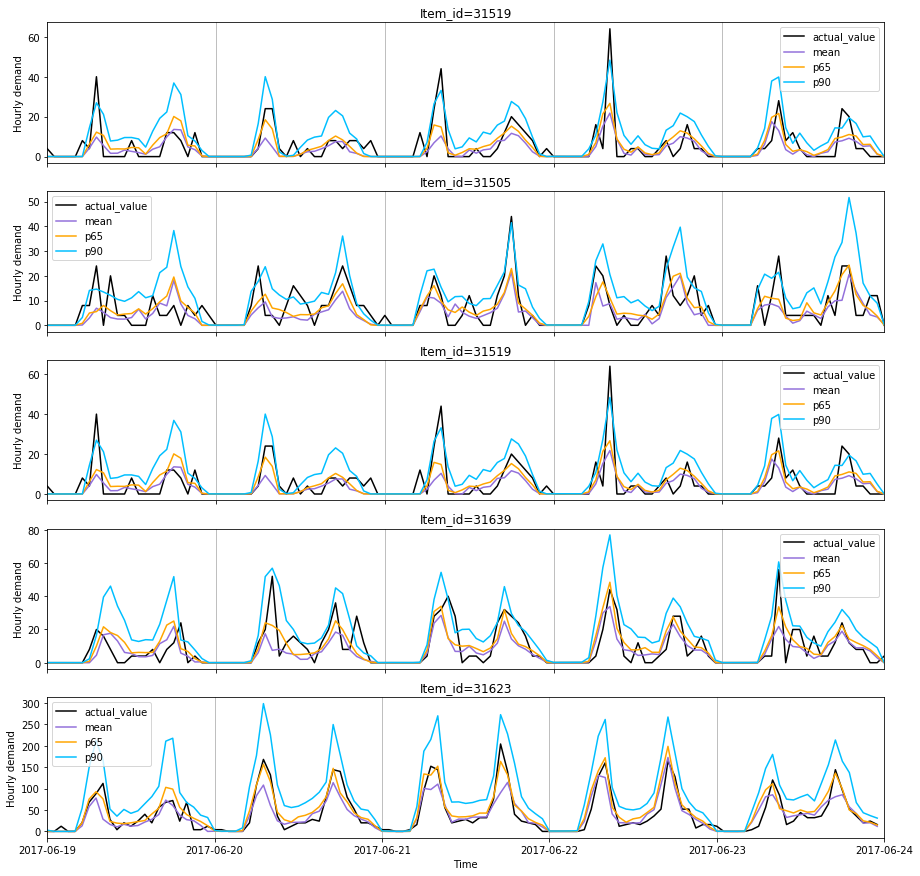

In [30]:

# Visualize items
np.warnings.filterwarnings('ignore')  
fig, axs = plt.subplots(len(random_items), 1, figsize=(15, 15), sharex=True)
# axx = axs.ravel()


for i in range(len(random_items)):
    
    item = random_items[i]
    zoomed = temp.loc[(temp[item_id]==item), :]

    zoomed[['actual_value']].plot(ax=axs[i], color='k')
    colors = ['mediumpurple', 'orange', 'deepskyblue']
    
    for j in range(len(quantile_cols)):
        quantile = quantile_cols[j]
        zoomed[[quantile]].plot(ax=axs[i], color=colors[j])
            
    axs[i].set_title(f"Item_id={item}")
    axs[i].set_xlabel("Time")    #date
    axs[i].set_ylabel("Hourly demand")   
    axs[i].grid(axis='x')
    axs[i].set_xticks(x[0:])
    axs[i].set_xticklabels([str(dt.date())[0:11] for dt in x[0:]])



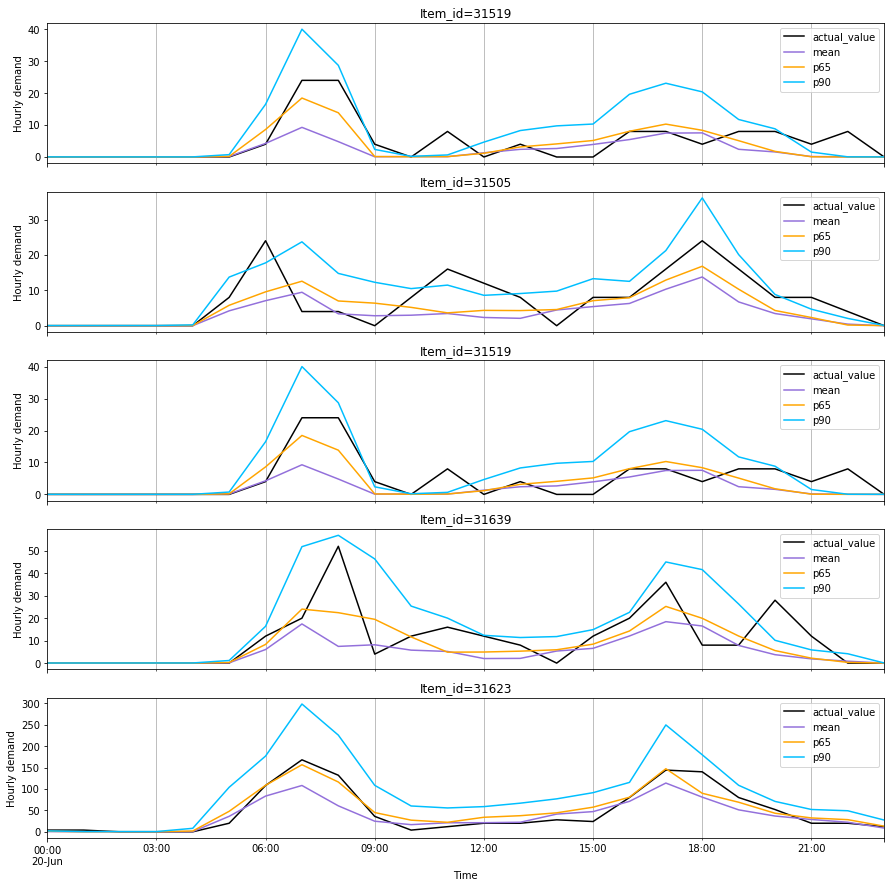

In [31]:

# Visualize items - zoom in to see hours
np.warnings.filterwarnings('ignore')  
fig, axs = plt.subplots(len(random_items), 1, figsize=(15, 15), sharex=True)


for i in range(len(random_items)):
    
    item = random_items[i]
    zoomed = temp.loc[(temp[item_id]==item), :]
    zoomed = zoomed['2017-06-20':'2017-06-20']

    zoomed[['actual_value']].plot(ax=axs[i], color='k')    
    colors = ['mediumpurple', 'orange', 'deepskyblue']
    
    for j in range(len(quantile_cols)):
        quantile = quantile_cols[j]
        zoomed[[quantile]].plot(ax=axs[i], color=colors[j])
            
    axs[i].set_title(f"Item_id={item}")
    axs[i].set_xlabel("Time")    #date
    axs[i].set_ylabel("Hourly demand")   
    axs[i].grid(which='minor', axis='x')


Above, peak hours for bicycle rental appear to be between 5-9am and 3-9pm.  For a real customer study, we really should select more data to verify the peak hours...
<br>

## Demo custom item-level accuracy 

An example customer metric request might be - tell me MAPE for my top-selling items, during peak hours, and tell me this before deploying the Predictor.  Also, please use this MAPE formula.  MAPE = sum( |yhat - y| / |y| ).
<br>
<br>
To tackle this, we'll use the raw actuals, forecasts we just exported from the Predictor backtest windows.  Steps to calculate:
<ul>
    <li>First, we'll segment the items into "fast" and "slow" categories, depending on how much demand they have. </li>
    <li>Then we'll calculate a custom accuracy MAPE for each group of items.</li>  
    <li>Finally, we'll do some visualizations of item demand actuals and forecasts.</li>
    </ul>

#### Get "fast" vs "slow" items

In [32]:

## CALCULATE DEMAND VELOCITY OF ITEMS

# categorize items
fast_moving_items, slow_moving_items = get_fast_slow_moving_items_all(df_eligible, timestamp, target_value, item_id)

# assign item velocity
df_eligible['velocity'] = "slow"
df_eligible.loc[(df_eligible.item_id.isin(fast_moving_items)), 'velocity'] = 'fast'

# checkit
print(df_eligible.velocity.value_counts(normalize=True, dropna=False))
df_eligible.sample(5)

average velocity of all items: 22.598857958600995
slow   0.64117
fast   0.35883
Name: velocity, dtype: float64


,item_id,timestamp,target_value,backtestwindow_start_time,backtestwindow_end_time,mean,p65,p90,day_of_week,window,velocity
172155,31412,2017-06-19 09:00:00,0.00000,2017-06-19,2017-06-19 23:00:00,0.00000,0.00000,0.00698,Monday,1,slow
174028,31613,2017-06-19 13:00:00,3.00000,2017-06-19,2017-06-19 23:00:00,1.90291,4.28828,9.27444,Monday,1,fast
2489,31120,2017-06-19 05:00:00,0.00000,2017-06-19,2017-06-19 23:00:00,0.00000,0.00000,0.00883,Monday,1,fast
86247,31066,2017-06-21 17:00:00,0.00000,2017-06-21,2017-06-21 23:00:00,0.58307,0.91214,1.95852,Wednesday,3,slow
192892,32067,2017-06-21 06:00:00,0.00000,2017-06-21,2017-06-21 23:00:00,0.00000,0.00000,0.00018,Wednesday,3,slow


In [33]:

## Display breakdown: how many fast vs slow-moving items

total_items_cnt = len(fast_moving_items) + len(slow_moving_items)
print(f"number of fast moving items: {len(fast_moving_items)}, ratio:{len(fast_moving_items) / total_items_cnt}")

print(f"number of slow moving items: {len(slow_moving_items)}, ratio: {len(slow_moving_items) / total_items_cnt}")


number of fast moving items: 167, ratio:0.3576017130620985
number of slow moving items: 300, ratio: 0.6423982869379015


#### Restrict to just peak hours
Assume peak hours for bicycle rental are Weekdays between 5-9am and 3-9pm.

In [34]:

## Add peak hour flags

# add day of week and time of day
df_eligible['day_of_week'] = df_eligible[timestamp].dt.day_name()
df_eligible['time_of_day'] = df_eligible[timestamp].dt.time

# morning commute start and end
mc_s = pd.to_datetime('05:00:00').time()
mc_e = pd.to_datetime('10:00:00').time()

# evening commute start and end
ec_s = pd.to_datetime('15:00:00').time()
ec_e = pd.to_datetime('21:00:00').time()

# initialize flags to zero
df_eligible['peak_flag'] = 0
df_eligible['weekend_flag'] = 0

# add weekend flag
df_eligible['weekend_flag'] = df_eligible[timestamp].dt.dayofweek
df_eligible['weekend_flag'] = (df_eligible['weekend_flag'] >= 5).astype(int)

# add morning commute
df_eligible.loc[( (df_eligible.weekend_flag==0)
                    & ((df_eligible['time_of_day'] <= mc_e) 
                        & (df_eligible['time_of_day'] >= mc_s)) ), 'peak_flag'] = 1

# add evening commute
df_eligible.loc[( (df_eligible.weekend_flag==0)
                    & ((df_eligible['time_of_day'] <= ec_e) 
                        & (df_eligible['time_of_day'] >= ec_s)) ), 'peak_flag'] = 1

# check you did the right thing
df_eligible.sample(70).sort_values('time_of_day')

,item_id,timestamp,target_value,backtestwindow_start_time,backtestwindow_end_time,mean,p65,p90,day_of_week,window,velocity,time_of_day,peak_flag,weekend_flag
179046,32020,2017-06-20 00:00:00,0.00000,2017-06-20,2017-06-20 23:00:00,0.00023,0.00031,0.00066,Tuesday,2,slow,00:00:00,0,0
134156,31602,2017-06-21 00:00:00,1.00000,2017-06-21,2017-06-21 23:00:00,0.30363,0.64861,1.16214,Wednesday,3,fast,00:00:00,0,0
78313,31711,2017-06-21 00:00:00,0.00000,2017-06-21,2017-06-21 23:00:00,0.00000,0.00000,0.00054,Wednesday,3,slow,00:00:00,0,0
122995,31805,2017-06-20 00:00:00,0.00000,2017-06-20,2017-06-20 23:00:00,0.00733,0.00495,0.00956,Tuesday,2,slow,00:00:00,0,0
11923,31411,2017-06-20 01:00:00,0.00000,2017-06-20,2017-06-20 23:00:00,0.00105,0.00092,0.00190,Tuesday,2,slow,01:00:00,0,0
78731,31249,2017-06-21 01:00:00,0.00000,2017-06-21,2017-06-21 23:00:00,0.00000,0.00000,0.04153,Wednesday,3,fast,01:00:00,0,0
79283,31097,2017-06-21 02:00:00,0.00000,2017-06-21,2017-06-21 23:00:00,0.00000,0.00000,0.00193,Wednesday,3,slow,02:00:00,0,0
135392,31054,2017-06-21 02:00:00,0.00000,2017-06-21,2017-06-21 23:00:00,0.00000,0.00000,0.00495,Wednesday,3,slow,02:00:00,0,0
57484,31266,2017-06-19 03:00:00,0.00000,2017-06-19,2017-06-19 23:00:00,0.00000,0.00000,0.01504,Monday,1,fast,03:00:00,0,0
1812,31076,2017-06-19 03:00:00,0.00000,2017-06-19,2017-06-19 23:00:00,0.00000,0.00000,0.00061,Monday,1,slow,03:00:00,0,0


In [35]:

## Restrict evaluation to just peak hours

print(df_eligible.shape)
df_eligible = df_eligible.loc[(df_eligible.peak_flag==1), :].copy()
print(df_eligible.shape)
df_eligible.sample(3)

(223392, 14)
(121004, 14)


,item_id,timestamp,target_value,backtestwindow_start_time,backtestwindow_end_time,mean,p65,p90,day_of_week,window,velocity,time_of_day,peak_flag,weekend_flag
160083,31641,2017-06-23 08:00:00,4.00000,2017-06-23,2017-06-23 23:00:00,3.41184,4.08939,6.50841,Friday,5,fast,08:00:00,1,0
220090,31010,2017-06-23 16:00:00,0.00000,2017-06-23,2017-06-23 23:00:00,0.44828,0.61703,1.91750,Friday,5,slow,16:00:00,1,0
41016,31222,2017-06-22 16:00:00,6.00000,2017-06-22,2017-06-22 23:00:00,8.91981,10.66268,17.37649,Thursday,4,fast,16:00:00,1,0


### Calculate custom metric MAPE per quantile for the "fast" item group <a class="anchor" id="mape"></a>

In [36]:

### CALCULATE MAPE PER QUANTILE ACROSS ALL BACKTEST WINDOWS FOR FAST GROUPS OF ITEMS

from collections import defaultdict
mape_by_moving_fast = dict()
mape_fast = []

# FAST ITEMS
windows_list = list(windows.window)
for q in quantile_cols:
    quantile_list = []
    for w in windows_list:
        temp = df_eligible.loc[((df_eligible.velocity=="fast")
                       & (df_eligible.window==w)), [target_value, q]].copy()
        mape_by_moving_fast[q,w] = temp.apply(lambda row: calc_mape(row[target_value], row[q]), axis=1)
        
        quantile_list.append(mape_by_moving_fast[q,w])
    mape_fast.append(np.mean(quantile_list))
        
mape_fast = pd.DataFrame(mape_fast).T
mape_fast.columns = quantile_cols
mape_fast.index.name = 'MAPE'
print("Fast Item Custom MAPE per quantile")
mape_fast

Fast Item Custom MAPE per quantile


,mean,p65,p90
MAPE,,,
0,0.50689,0.56042,1.17427


In [37]:
### LOOK UP STANDARD METRICS FOR THE GROUP OF "FAST" ITEMS DURING PEAK HOURS

fast_metrics = accuracy_df.loc[(accuracy_df.item_id.isin(fast_moving_items)), :].copy()
# drop the summary row
fast_metrics = fast_metrics.loc[(fast_metrics.backtest_window != "Summary"), :].copy()
# calc mean of the standard metrics across 5 backtest windows
fast_metrics = fast_metrics.mean()
fast_metrics['item_id'] = "mean"

print("Fast Item Mean Standard Metrics per quantile")
fast_metrics

Fast Item Mean Standard Metrics per quantile


item_id         mean
wQL[0.65]    0.63130
wQL[0.9]     0.40132
RMSE         2.35709
WAPE        35.98397
dtype: object